# `Figure`: Steady-State Analysis of the Choice Behavior of _Klebsiella oxytoca_
Fill me in

## Setup

In [1]:
include("Include.jl");

In [2]:
parameters = loadparameters();

In [3]:
parameters

Dict{String, Any} with 5 entries:
  "lactose"   => Dict{String, Any}("death_rate_constant"=>"0.026", "saturation_…
  "glucose"   => Dict{String, Any}("death_rate_constant"=>"0.029", "saturation_…
  "fructose"  => Dict{String, Any}("death_rate_constant"=>"0.025", "saturation_…
  "xylose"    => Dict{String, Any}("death_rate_constant"=>"0.022", "saturation_…
  "arabinose" => Dict{String, Any}("death_rate_constant"=>"0.027", "saturation_…

In [4]:
number_of_sugars = length(parameters)

5

In [5]:
list_of_sugars = keys(parameters) |> collect |> sort

5-element Vector{String}:
 "arabinose"
 "fructose"
 "glucose"
 "lactose"
 "xylose"

## `Task 1`: Compute the $\hat{b}_{i}$ values for each sugar in our collection
The $\hat{b}_{i}$ values are the scaled cost coefficients that appear in the resource constraint equation. We compute the expression cost coefficients $\hat{b}_{i}$ using a steady-state approximation:
$$
\begin{equation}
\hat{b}_{i}^{-1} \approx \frac{1}{\delta_{i}}\cdot{\left(\frac{1}{\tau_{i}}+\lambda_{i}\right)}
\end{equation}
$$
where we made use of the property that the cybernetic control variable $u_{i} \rightarrow 1$ in this condition,  and defined $\delta_{i} \equiv \left(\mu_{g}^{max} + k_{d}^{(i)}\right)$. The $\lambda_{i}$ denotes the rate or non-regulated gene expression for enzyme $e_{i}$.

In [6]:
b̂ = zeros(number_of_sugars);
for i ∈ eachindex(list_of_sugars)
    sugar = list_of_sugars[i];
    p = parameters[sugar];

    λᵢ = p["lambda"] |> x-> parse(Float64,x);
    kᵢ = p["beta"] |> x-> parse(Float64,x);
    μᵢ = p["specific_growth_rate"] |> x-> parse(Float64,x);
    τᵢ = p["tau"] |> x-> parse(Float64,x);
    δᵢ = (μᵢ + kᵢ);
    b̂[i] = ((1/δᵢ)*(1/τᵢ + λᵢ))^-1;
end

In [7]:
b̂

5-element Vector{Float64}:
 0.6537356321839081
 0.5481260647359455
 0.7035440613026821
 0.6226053639846744
 0.5416666666666667

In [8]:
bounds_enzyme_values = zeros(number_of_sugars,2);
for i ∈ 1:number_of_sugars
    bounds_enzyme_values[i,1] = 0.0
    bounds_enzyme_values[i,2] = 1/b̂[i]
end

## `Task 2`: Compute the $\gamma_{i}$ values for each sugar in our collection

In [9]:
Sₒ = [
    2.0  ; # 1 arabinose
    4.0  ; # 2 fructose
    0.33 ; # 3 glucose
    1.5  ; # 4 lactose
    2.0  ; # 5 xylose
];

In [10]:
cₒ = 0.005; # units: gDW/L
γ = zeros(number_of_sugars)
for i ∈ eachindex(list_of_sugars)
    sugar = list_of_sugars[i];
    p = parameters[sugar];

    emax = p["emax"] |> x-> parse(Float64,x);
    Kᵢ = p["saturation_constant"] |> x-> parse(Float64,x);
    μᵢ = p["specific_growth_rate"] |> x-> parse(Float64,x);
    sᵢ = Sₒ[i];
    γ[i] = ((μᵢ/emax)*sᵢ*cₒ)/(Kᵢ+sᵢ);
end

In [11]:
γ

5-element Vector{Float64}:
 0.0031889543033361374
 0.0028897583627139054
 0.003687398580121705
 0.0007393438697318008
 0.0020189393939393937

## `Task 3`: Predict `binary` choice behavior

In [12]:
my_test_sugars = ["glucose", "fructose"];
idx_test_sugars = Array{Int64,1}();
for i ∈ eachindex(my_test_sugars)
    sugar = my_test_sugars[i];
    idx = findfirst(x-> x==sugar, list_of_sugars);
    push!(idx_test_sugars,idx)
end

In [13]:
idx_test_sugars

2-element Vector{Int64}:
 3
 2

In [14]:
problem = build(MySimpleLinearChoiceProblem, (
    α = γ[idx_test_sugars],
    c = b̂[idx_test_sugars],
    I = 1.0,
    bounds = bounds_enzyme_values[idx_test_sugars,:],
    initial = [0.1, 0.1]  
));

In [15]:
problem

MySimpleLinearChoiceProblem([0.003687398580121705, 0.0028897583627139054], [0.7035440613026821, 0.5481260647359455], 1.0, [0.0 1.4213750850918991; 0.0 1.8243978243978243], [0.1, 0.1])

In [16]:
soln = solve(problem)

Dict{String, Any} with 3 entries:
  "argmax"          => [0.0, 1.8244]
  "budget"          => 1.0
  "objective_value" => 0.00527207

In [17]:
obj_value = soln["objective_value"]

0.005272068869970668

In [18]:
test_soln = soln["argmax"]

2-element Vector{Float64}:
 0.0
 1.8243978243978243

In [19]:
test_soln[1]*γ[idx_test_sugars[1]]+test_soln[2]*γ[idx_test_sugars[2]]

0.005272068869970668

## `Task 4`: Visualize

In [20]:
bounds_enzyme_values

5×2 Matrix{Float64}:
 0.0  1.52967
 0.0  1.8244
 0.0  1.42138
 0.0  1.60615
 0.0  1.84615

In [21]:
ϵ = 0.01;
number_of_steps = Int(floor((1.0 - 0.0)/ϵ));
budget_line = zeros(number_of_steps+1,2);
for i = 1:(number_of_steps+1)
    θ = ϵ*(i-1)
    budget_line[i,1] = θ*(1/b̂[idx_test_sugars[1]])
    budget_line[i,2] = (1-θ)*(1/b̂[idx_test_sugars[2]])
end

In [22]:
budget_line

101×2 Matrix{Float64}:
 0.0        1.8244
 0.0142138  1.80615
 0.0284275  1.78791
 0.0426413  1.76967
 0.056855   1.75142
 0.0710688  1.73318
 0.0852825  1.71493
 0.0994963  1.69669
 0.11371    1.67845
 0.127924   1.6602
 0.142138   1.64196
 0.156351   1.62371
 0.170565   1.60547
 ⋮          
 1.26502    0.200684
 1.27924    0.18244
 1.29345    0.164196
 1.30767    0.145952
 1.32188    0.127708
 1.33609    0.109464
 1.35031    0.0912199
 1.36452    0.0729759
 1.37873    0.0547319
 1.39295    0.036488
 1.40716    0.018244
 1.42138    0.0

In [23]:
model = build(VLLinearUtilityFunction, (
    α = γ[idx_test_sugars],
));

In [24]:
bounds_enzyme_values[idx_test_sugars[1],:]

2-element Vector{Float64}:
 0.0
 1.4213750850918991

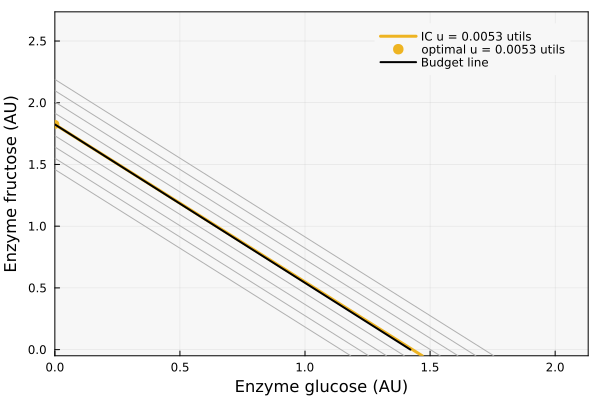

In [25]:
q = plot();
θ_array = range(0.80,stop=1.2,length=9) |> collect;
for i ∈ eachindex(θ_array)
    θᵢ = θ_array[i];
    indiff_array = indifference(model,  utility = θᵢ*obj_value, 
        bounds = 1.25*bounds_enzyme_values[idx_test_sugars[1],:] , ϵ=0.01)

    line_color = :gray69
    lwv = 1
    labeltext = ""
    if (θᵢ == 1.0)
        line_color = :goldenrod2
        lwv = 3
        labeltext="IC u = $(round(θᵢ*obj_value,digits=4)) utils"
    end
    
    plot!(indiff_array[:,1],indiff_array[:,2], xlims=(0.0,1.5*(1/b̂[idx_test_sugars[1]])), 
        ylims=(-0.05,1.5*(1/b̂[idx_test_sugars[2]])), lw=lwv, c=line_color, label=labeltext, 
        bg=:gray97, background_color_outside="white", framestyle = :box, fg_legend = :transparent)
end
current()
scatter!([test_soln[1]],[test_soln[2]], c=:goldenrod2, msc=:goldenrod2, ms=5, label="optimal u = $(round(obj_value,digits=4)) utils")
plot!(budget_line[:,1],budget_line[:,2],c=:black, lw=2, label="Budget line")
xlabel!("Enzyme $(my_test_sugars[1]) (AU)", fontsize=18)
ylabel!("Enzyme $(my_test_sugars[2]) (AU)", fontsize=18)

In [26]:
savefig(joinpath(_PATH_TO_FIGS, "Fig-$(my_test_sugars[1])-$(my_test_sugars[2])-IC-Budget-GB-lambda.pdf"))

"/Users/jeffreyvarner/Desktop/julia_work/kompala_model_analysis/figs/Fig-glucose-fructose-IC-Budget-GB-lambda.pdf"